<a href="https://colab.research.google.com/github/samansadeghii/Sentiment_Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark


tar: spark-3.4.1-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [2]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark


tar: spark-3.4.1-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"


In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"


In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark


In [ ]:
!ls /content/spark-3.4.1-bin-hadoop3/python/lib/


py4j-0.10.9.7-src.zip  PY4J_LICENSE.txt  pyspark.zip


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"


In [ ]:
import findspark
findspark.init()


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("SentimentAnalysis").getOrCreate()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


In [ ]:
file_path = "/content/training.1600000.processed.noemoticon.csv"
df = spark.read.csv(file_path, encoding='latin1', header=False)
df.show(5)


+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col

df = df.select(
    col("_c0").alias("label"),
    col("_c5").alias("tweet")
)
df.show(5)


+-----+--------------------+
|label|               tweet|
+-----+--------------------+
|    0|@switchfoot http:...|
|    0|is upset that he ...|
|    0|@Kenichan I dived...|
|    0|my whole body fee...|
|    0|@nationwideclass ...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import regexp_replace, lower


df_clean = df.withColumn('tweet', regexp_replace('tweet', r'@\w+', ''))
df_clean = df_clean.withColumn('tweet', regexp_replace('tweet', r'http\S+', ''))
df_clean = df_clean.withColumn('tweet', regexp_replace('tweet', r'[^a-zA-Z\s]', ''))
df_clean = df_clean.withColumn('tweet', lower('tweet'))

df_clean.show(5, truncate=False)


+-----+---------------------------------------------------------------------------------------------------------+
|label|tweet                                                                                                    |
+-----+---------------------------------------------------------------------------------------------------------+
|0    |   awww thats a bummer  you shoulda got david carr of third day to do it d                               |
|0    |is upset that he cant update his facebook by texting it and might cry as a result  school today also blah|
|0    | i dived many times for the ball managed to save   the rest go out of bounds                             |
|0    |my whole body feels itchy and like its on fire                                                           |
|0    | no its not behaving at all im mad why am i here because i cant see you all over there                   |
+-----+---------------------------------------------------------------------------------

In [ ]:
df_clean = df_clean.filter(df_clean['tweet'] != '')
df_clean = df_clean.filter(df_clean['tweet'].isNotNull())
df_clean = df_clean.filter(df_clean['tweet'].rlike(r'\w{3,}'))

df_clean.show(5, truncate=False)


+-----+---------------------------------------------------------------------------------------------------------+
|label|tweet                                                                                                    |
+-----+---------------------------------------------------------------------------------------------------------+
|0    |   awww thats a bummer  you shoulda got david carr of third day to do it d                               |
|0    |is upset that he cant update his facebook by texting it and might cry as a result  school today also blah|
|0    | i dived many times for the ball managed to save   the rest go out of bounds                             |
|0    |my whole body feels itchy and like its on fire                                                           |
|0    | no its not behaving at all im mad why am i here because i cant see you all over there                   |
+-----+---------------------------------------------------------------------------------

In [ ]:
positive_words = ["good", "great", "happy", "love", "excellent", "best", "fantastic", "like", "enjoy", "awesome"]
negative_words = ["bad", "sad", "hate", "terrible", "awful", "worst", "angry", "dislike", "horrible", "problem"]


In [ ]:
pos_broadcast = spark.sparkContext.broadcast(positive_words)
neg_broadcast = spark.sparkContext.broadcast(negative_words)


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def sentiment_score(text):
    pos = sum(word in text.split() for word in pos_broadcast.value)
    neg = sum(word in text.split() for word in neg_broadcast.value)
    return 1 if pos > neg else 0

sentiment_udf = udf(sentiment_score, IntegerType())


In [ ]:
df_final = df_clean.withColumn("predicted_sentiment", sentiment_udf("tweet"))
df_final.select("tweet", "label", "predicted_sentiment").show(10, truncate=False)


+---------------------------------------------------------------------------------------------------------+-----+-------------------+
|tweet                                                                                                    |label|predicted_sentiment|
+---------------------------------------------------------------------------------------------------------+-----+-------------------+
|   awww thats a bummer  you shoulda got david carr of third day to do it d                               |0    |0                  |
|is upset that he cant update his facebook by texting it and might cry as a result  school today also blah|0    |0                  |
| i dived many times for the ball managed to save   the rest go out of bounds                             |0    |0                  |
|my whole body feels itchy and like its on fire                                                           |0    |1                  |
| no its not behaving at all im mad why am i here because i ca

In [ ]:
from pyspark.sql.functions import col


df_final = df_final.withColumn("label_binary", (col("label") == 4).cast("integer"))

accuracy = df_final.filter(col("label_binary") == col("predicted_sentiment")).count() / df_final.count()
print("Accuracy:", accuracy)


Accuracy: 0.5615803597790199


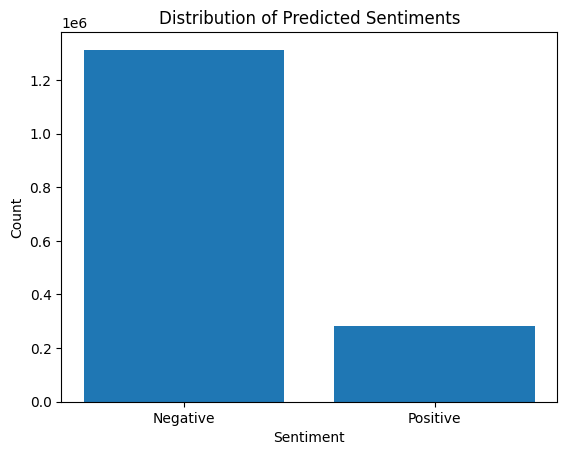

In [ ]:
sentiment_counts = df_final.groupBy("predicted_sentiment").count().toPandas()

import matplotlib.pyplot as plt

plt.bar(sentiment_counts["predicted_sentiment"], sentiment_counts["count"])
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Predicted Sentiments")
plt.show()


In [ ]:
from pyspark.sql.functions import col

total_positive = df_final.filter(col("label_binary") == 1).count()
total_negative = df_final.filter(col("label_binary") == 0).count()
correct_positive = df_final.filter((col("label_binary") == 1) & (col("predicted_sentiment") == 1)).count()
correct_negative = df_final.filter((col("label_binary") == 0) & (col("predicted_sentiment") == 0)).count()

print("Accuracy for Positive Tweets:", correct_positive / total_positive)
print("Accuracy for Negative Tweets:", correct_negative / total_negative)


Accuracy for Positive Tweets: 0.23851696902660416
Accuracy for Negative Tweets: 0.8844538473397062


In [ ]:
df_final.filter(col("label_binary") != col("predicted_sentiment")) \
    .select("tweet", "label_binary", "predicted_sentiment") \
    .show(10, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------+------------+-------------------+
|tweet                                                                                                                                  |label_binary|predicted_sentiment|
+---------------------------------------------------------------------------------------------------------------------------------------+------------+-------------------+
|my whole body feels itchy and like its on fire                                                                                         |0           |1                  |
| ahh ive always wanted to see rent  love the soundtrack                                                                                |0           |1                  |
| awe i love you too  am here  i miss you                                                                                               |0       

In [ ]:

positive_words += ["amazing", "enjoyed", "wonderful"]
negative_words += ["boring", "disappointed", "annoyed"]



In [ ]:
df_final.limit(1000).toPandas().to_csv("sentiment_results_sample.csv", index=False)
from google.colab import files
files.download("sentiment_results_sample.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>